## Введение в анализ данных, ИАД-1

## НИУ ВШЭ, 2019-20 учебный год

### Домашнее задание №2

Задание выполнила: Кудрявцева Евгения Алексеевна

# kNN своими руками (4)

Реализуйте взвешенный алгоритм kNN для регрессии. Пусть нам нужно вычислить значение $y$ для некоторого $x$ при известных данных $\left(x_1, y_1\right), \ldots, \left(x_\ell, y_\ell\right)$. Предсказанием вашего регрессора будет являться

$$
\hat{y} = \frac{\sum\limits_{i=1}^kw_iy_{(i)}}{\sum\limits_{i=1}^kw_i},
$$
где $\left(x_{(1)}, y_{(1)}\right), \ldots, \left(x_{(k)}, y_{(k)}\right)$ - ближайшие $k$ объектов к $x$ по некоторой метрике $d(\cdot, \cdot)$, а $w_i = \frac{1}{d\left(x, x_{(i)}\right)}$. Ваш алгоритм должен уметь работать с двумя метриками:

$$
d\left(x_{(i)}, x\right) = \|x_{(i)} - x\|_2 = \sqrt{\sum\limits_{j=1}^n\left(x_{(i)}^j - x^j\right)^2}\qquad\text{(евклидова)}
$$
$$
d\left(x_{(i)}, x\right) = \|x_{(i)} - x\|_1 = \sum\limits_{j=1}^n\left|x_{(i)}^j - x^j\right|\qquad\text{(манхэттена)}
$$

Сверьте для нескольких комбинаций различных параметров свой результат на искусственной выборке с результатом соответствующего алгоритма из `sklearn` по метрике качества MSE.

In [146]:
from math import sqrt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import numpy.linalg as la
from sklearn.linear_model import HuberRegressor as HR

In [147]:
class KNN:
    def __init__(self, metric='euclid', k=5):
        """
        PARAMETERS:
        metric ('euclid' or 'manhattan')
        k - number of nearest neighbors
        """

        self.metric = metric
        self.k = k

        self.X_train = None
        self.y_train = None


    def fit(self, X_train, y_train):
        """
        INPUT:
        X_train - np.array of shape (l, d)
        y_train - np.array of shape (l,)
        """
        self.X_train = X_train
        self.y_train = y_train

        return self


    def predict(self, X_test):
        """
        INPUT:
        X_test - np.array of shape (m, d)

        OUTPUT:
        y_pred - np.array of shape (m,)
        """

        pred = []
        for j in range(X_test.shape[0]):

            testDist = []

            for m in range(self.X_train.shape[0]):

                distance = 0
                if self.metric == 'euclid':
                    distance = la.norm(X_test[j] - self.X_train[m])
                    
                elif self.metric == 'manhattan':
                    distance = sum(abs(X_test[j] - self.X_train[m]))

                testDist.append(distance)

            allDist = np.array(testDist.copy())
            testDist.sort()
            testDist = np.array(testDist[:self.k])
            index = []
            for i in range(self.k):
                row, = np.where(allDist == testDist[i])[0]
                index.append(row)

            weights = np.where(testDist != 0, 1/np.array(testDist), 0)
            sum_weights = sum(weights)
            sum_w_p = sum(np.array(weights) * np.array(self.y_train[index]))
            pred.append(sum_w_p / sum_weights)

        return pred
        pass

In [148]:
np.random.seed(17032019)
X_train = np.random.randn(1000, 50)
y_train = np.random.randn(1000,)
X_test = np.random.randn(500, 50)
y_test = np.random.randn(500,)

In [149]:
my_KNN = KNN()
my_KNN = my_KNN.fit(X_train, y_train)
my_pred = my_KNN.predict(X_test)
print('myMSE:', mean_squared_error(y_test, my_pred))

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
print('sklearnMSE:', mean_squared_error(y_test, pred))

myMSE: 1.143364989935662
sklearnMSE: 1.143019350619603


# Линейная регрессия своими руками (4)

Реализуйте линейную регрессию с градиентным спуском для [функции потерь Хьюбера](https://en.wikipedia.org/wiki/Huber_loss):

$$
L_\delta\left(y, \hat{y}\right) =
\begin{cases}
\frac{1}{2}\left(y - \hat{y}\right)^2, \qquad &|y - \hat{y}| \leq \delta\\
\delta\left|y - \hat{y}\right| - \frac{1}{2}\delta^2,\qquad & \text{otherwise}
\end{cases}
$$

В таком случае общее значение функции потерь на всем датасете $(x_1, y_1), \ldots, (x_\ell, y_\ell)$ будет равно

$$
L = \frac{1}{\ell}\sum\limits_{i=1}^\ell L_\delta\left(y_i, \hat{y}_i\right)
$$

Проверьте работу вашего метода: выведите результаты его работы на той же искусственной выборке, что и в задаче выше (в качестве метрик качества используйте MSE и Huber loss). Постройте график зависимости значения функции потерь от итерации градиентного спуска.

*Вы можете опустить единичный признак в модели и не добавлять его в данные. Для данной искусственной выборки это не актуально, потому что целевая переменная в этом случае является случайной величиной из стандартного нормального распределения со средним 0.*

*Вектор весов в градиентном спуске можете инициализировать нулями.*

In [150]:
import matplotlib as plt

In [151]:
class LinearRegressionHuber:
    def __init__(self, delta=1.0, max_iter=1000, tol=1e-6, eta=1e-2):
        """
        PARAMETERS:
        delta - scalar in Huber loss
        max_iter - maximum possible number of iterations in Gradient Descent
        tol - precision for stopping criterion in Gradient Descent
        eta - step size in Gradient Descent
        """

        self.delta = delta
        self.max_iter = max_iter
        self.tol = tol
        self.eta = eta

        self.w = None
        self.loss_history = None

    def fit(self, X_train, y_train):
        """
        INPUT:
        X_train - np.array of shape (l, d)
        y_train - np.array of shape (l,)
        """
        self.loss_history = []

        self.w = np.zeros(X_train.shape[1])
        w_old = self.w.copy()
        h = np.zeros(X_train.shape[1])
        for i in range(self.max_iter):
            self.w -= h
            self.loss_history.append(self.calc_loss(X_train, y_train))
            grad = self.calc_gradient(X_train, y_train)
            h = self.eta * h + self.eta * grad
            if abs(la.norm(w_old - self.w)) < self.tol and i != 0:
                break

        return self.loss_history

    def predict(self, X_test):
        """
        INPUT:
        X_test - np.array of shape (m, d)

        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        pred = np.dot(X_test, self.w)
        return pred
        pass

    def calc_gradient(self, X, y):
        """
        Calculates the gradient of Huber loss by weights.

        INPUT:
        X - np.array of shape (l, d)
        y - np.array of shape (l,)

        OUTPUT:
        grad - np.array of shape (d,)
        """
        y_i = np.dot(X, self.w)
        n = la.norm(y - y_i)
        if n <= self.delta:
            np.dot(X.T, (np.dot(X, self.w) - y)) / y.shape[0]
            return np.dot(X.T, (np.dot(X, self.w) - y)) / y.shape[0]
        else:
            return self.delta * np.dot(X.T, np.sign(np.dot(X, self.w) - y)) / y.shape[0]
        pass

    def calc_loss(self, X, y):
        """
        Calculates the Huber loss.

        INPUT:
        X - np.array of shape (l, d)
        y - np.array of shape (l,)

        OUTPUT:
        loss - float
        """
        n = y - np.dot(X, self.w)
        if la.norm(n) <= self.delta:
            return (1/2) * la.norm(n)
        else:
            return self.delta * la.norm(n) - (1/2) * self.delta

        pass

In [152]:
np.random.seed(17032019)
X_train = np.random.randn(1000, 50)
y_train = np.random.randn(1000,)
X_test = np.random.randn(500, 50)
y_test = np.random.randn(500,)

In [153]:
my_hr = LinearRegressionHuber()
loss = my_hr.fit(X_train, y_train)
my_pred = my_hr.predict(X_test)
print('myMSE:', mean_squared_error(y_test, my_pred))
hr = HR()
hr.fit(X_train, y_train)
pred = hr.predict(X_test)
print('sklearnMSE:', mean_squared_error(y_test, pred))

myMSE: 1.0907302356656396
sklearnMSE: 1.095104163225779


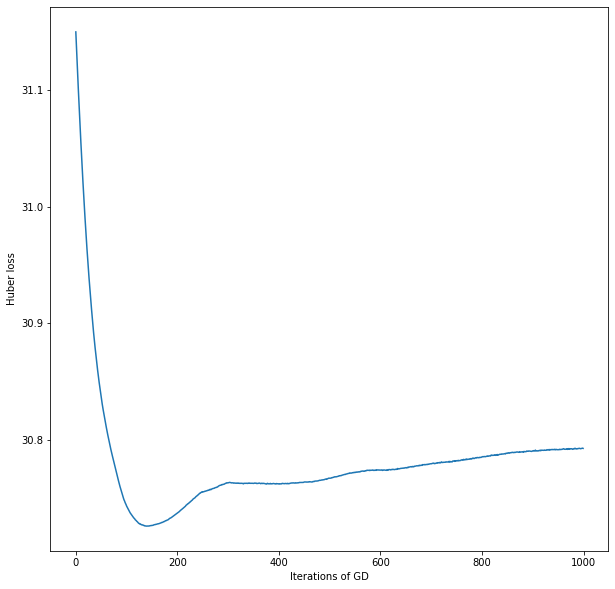

In [154]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('Iterations of GD')
ax.set_ylabel('Huber loss')
plt.plot(loss)
plt.show()

# Практика

Пожалуйста, при использовании различных функций из библиотек импортируйте все, что вам понадобилось в данной части, в следующем блоке:

In [155]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from math import sqrt

%matplotlib inline

В этом домашнем задании вы поработаете с данными из другого соревнования на Kaggle: https://www.kaggle.com/c/house-prices-advanced-regression-techniques. Задача - предсказание цены дома.

In [156]:
data = pd.read_csv('train.csv', header=0)

In [157]:
data.columns
data.shape

(1460, 81)

In [158]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [159]:
data.drop('Id', axis=1, inplace=True)

## 1 (1)

Есть ли в данных пропуски? Если да, то для каждого столбца, в котором они имеются, посчитайте их количество и их долю от общего числа значений. Что вы наблюдаете?

In [160]:
nan = pd.isna(data).sum()
nan2 = nan[nan!=0]

print(f'Пропуски:\n\n{nan2}\n\n\nДоля пропусков:\n\n{nan2/data.shape[0]}')

Пропуски:

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


Доля пропусков:

LotFrontage     0.177397
Alley           0.937671
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64


Есть столбцы, где почти все значения NaN, и наоборот, где пропуски меньше 1%

## 2 (1)

Избавьтесь от пропусков. Для каждого из примененных методов обоснуйте свое решение. **Проверьте, что вы действительно избавились от пропусков.**

*Напоминание. В зависимости от типа столбца, можно заполнить пропуски, например, средним арифметическим, медианой, модой, можно какими-то отдельными значениями. А можно такие столбцы вообще удалить.*

Сначала разберемся со столбцами, где больше всего пропусков.
В столбцах ***Alley***, ***PoolQC, MiscFeature, Fence*** почти 100% пропусков, так что имеет смысл их удалить.


In [161]:
data.drop(['Alley', 'PoolQC', 'MiscFeature', 'Fence'], axis=1, inplace=True)
data.shape

(1460, 76)

In [162]:
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,112,0,0,0,0,4,2010,WD,Normal,142125


В столбце ***Electrical*** всего 1 пропуск. Логично удалить эту строку, чтобы она ничего нам не портила

In [163]:
print(data.shape[0])
index = data[pd.isna(data['Electrical'])].index[0]
data.dropna(subset=['Electrical'], inplace=True)
data.shape[0]


1460


1459

In [164]:
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,112,0,0,0,0,4,2010,WD,Normal,142125


Пропуски в категоральных признаках заменим на None, в вещественных на медиану

In [165]:
categoral = data.columns[data.dtypes == 'object']
non_categoral = data.columns[data.dtypes != 'object']

In [166]:
X_real = data[non_categoral]
X_cat = data[categoral]

mis_replacer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_real = mis_replacer.fit_transform(X_real)

mis_replacer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='None')
X_cat = mis_replacer.fit_transform(X_cat)

X_cat = pd.DataFrame(X_cat, columns=categoral)
X_real = pd.DataFrame(X_real, columns=non_categoral)

data = pd.concat([X_real, X_cat], axis=1)

In [167]:
nan = pd.isna(data).sum()
nan2 = nan[nan!=0]

nan2

Series([], dtype: int64)

Пропусков больше нет!

## 3 (1)

Обработайте категориальные признаки. В их обнаружении вам может помочь синтаксис `pandas` (например, можно обратить внимание на типы столбцов), а также описание датасета и его исследование. Объясните выбор метода (one-hot-encoding, label encoding, ...)

In [168]:
categoral = data.columns[data.dtypes == 'object']
categoral

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

Взглянем на значения столбцов

In [169]:
for col in categoral:
    print(f'{col}: {data[col].unique()}')

MSZoning: ['RL' 'RM' 'C (all)' 'FV' 'RH']
Street: ['Pave' 'Grvl']
LotShape: ['Reg' 'IR1' 'IR2' 'IR3']
LandContour: ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities: ['AllPub' 'NoSeWa']
LotConfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope: ['Gtl' 'Mod' 'Sev']
Neighborhood: ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1: ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2: ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType: ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle: ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle: ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl: ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
Exterior1st: ['VinylSd' 'MetalSd' 'Wd Sdng' 

Я думаю, что нужно убрать столбец ***Neighbourhoods***, потому что в них значения такие, что могут меняться, то есть из неупорядоченного множества, что может сказаться на качестве модели.

In [170]:
data.drop(['Neighborhood'], axis=1, inplace=True)

data.shape[1]

75

In [171]:
data = pd.get_dummies(data, drop_first=True)
data.shape

(1459, 223)

In [172]:
data

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,0,0,0,0,1,0,0,0,1,0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,0,0,0,0,1,0,0,0,1,0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,0,0,0,0,1,0,0,0,1,0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,60.0,62.0,7917.0,6.0,5.0,1999.0,2000.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0
1455,20.0,85.0,13175.0,6.0,6.0,1978.0,1988.0,119.0,790.0,163.0,...,0,0,0,0,1,0,0,0,1,0
1456,70.0,66.0,9042.0,7.0,9.0,1941.0,2006.0,0.0,275.0,0.0,...,0,0,0,0,1,0,0,0,1,0
1457,20.0,68.0,9717.0,5.0,6.0,1950.0,1996.0,0.0,49.0,1029.0,...,0,0,0,0,1,0,0,0,1,0


## 4 (0.5)

Вычислите и визуализируйте попарную корреляцию Пирсона между всеми признаками. Какие выводы можно сделать?

*Для визуализации можно использовать `seaborn.heatmap()`.*

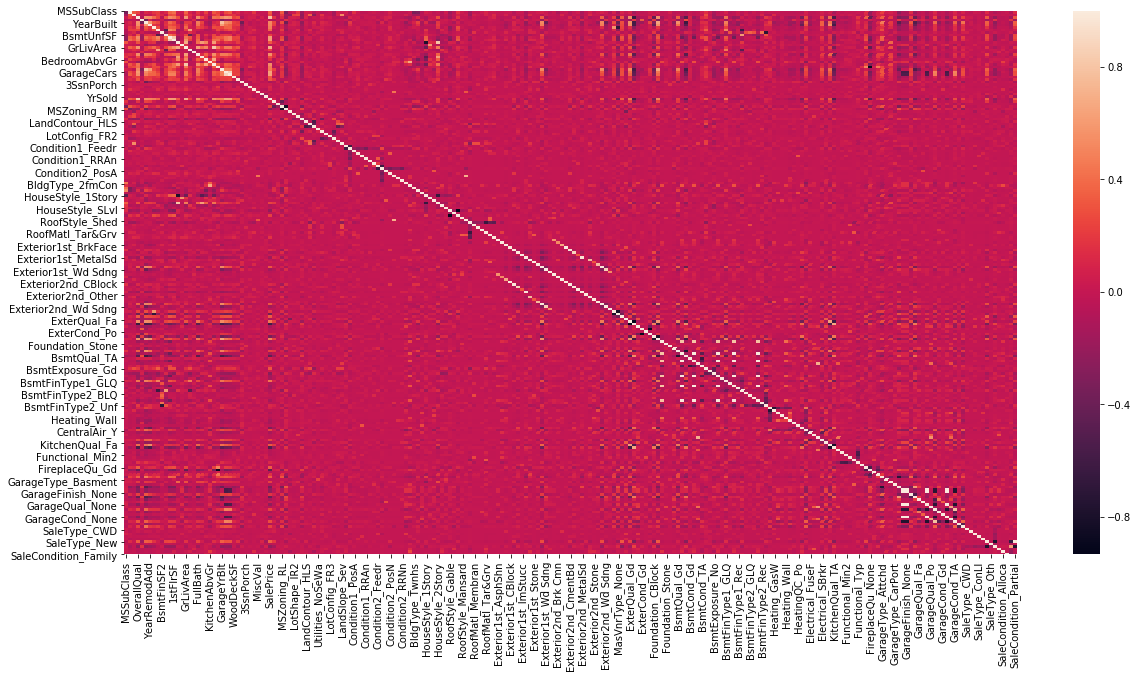

In [173]:
fig, ax = plt.subplots(figsize=(20,10))

sns.heatmap(data.corr(method='pearson'))

Не знаю какие супер крутые выводы можно сделать. Понятно, что признаки с одинаковыми названиями зависят друг от друга и у них корреляция положительная. Также видно, что прямую зависимость имеют общая Quality и Quality отдельных признаков. Многие признаки имеют прямую зависимость друг от друга, многие обратную

## 5 (0.5)

Найдите признаки с максимальным и минимальным **абсолютным** значением коэффициента корреляции Пирсона с предсказываемым значением. Изобразите на графиках зависимость найденных признаков от предсказываемого значения.

*Не забудьте указать название графика и обозначить, что изображено по каждой из осей.*

Минимум

In [174]:
prs = abs(data.corr(method='pearson'))
print(prs['SalePrice'].min())
prs[prs['SalePrice'] == prs['SalePrice'].min()]

6.41173481204964e-05


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
BsmtFinType2_GLQ,0.053801,0.049055,0.000225,0.002039,0.005938,0.019466,0.016384,0.049907,0.04594,0.373074,...,0.005772,0.005772,0.029733,0.004468,0.01768,0.005161,0.008964,0.011604,0.027733,0.030131


Максимум

In [175]:
print(prs[prs['SalePrice'] < 1]['SalePrice'].max())
prs[prs['SalePrice'] == prs[prs['SalePrice'] < 1]['SalePrice'].max()]

0.7910686627656242


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
OverallQual,0.032936,0.234323,0.105786,1.0,0.092243,0.573334,0.551605,0.410062,0.239265,0.059291,...,0.004238,0.021208,0.327328,0.058,0.224861,0.041715,0.04501,0.025585,0.143069,0.323208


Графики

Text(0, 0.5, 'SalePrice')

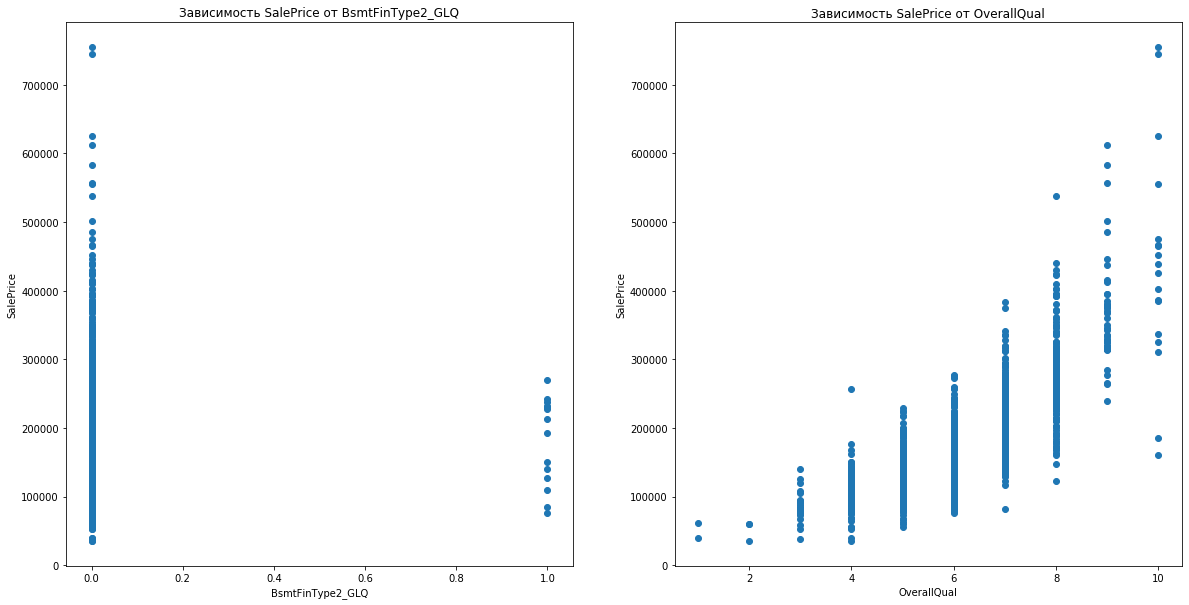

In [176]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].scatter(x=data['BsmtFinType2_GLQ'], y=data['SalePrice'])
ax[0].set_title('Зависимость SalePrice от BsmtFinType2_GLQ')
ax[0].set_xlabel('BsmtFinType2_GLQ')
ax[0].set_ylabel('SalePrice')

ax[1].scatter(x=data['OverallQual'], y=data['SalePrice'])
ax[1].set_title('Зависимость SalePrice от OverallQual')
ax[1].set_xlabel('OverallQual')
ax[1].set_ylabel('SalePrice')

## 6 (0.5)

Постройте гистограмму распределения предсказываемого значения. Для избавления от разницы в масштабах, а также «смещения» распределения переменной в сторону нормального (что бывает полезно при статистическом анализе), можно прологарифмировать ее (это обратимое преобразование, поэтому целевую переменную легко восстановить). В данном случае воспользуйтесь `numpy.log1p`, чтобы сделать преобразование $y \to \ln\left(1 + y\right)$. Постройте гистограмму распределения от нового предсказываемого значения. Опишите наблюдения.

*В дальнейшем используйте в качестве предсказываемого значения вектор, который получился после логарифмирования.*

(array([  5.,  12.,  54., 184., 470., 399., 220.,  90.,  19.,   6.]),
 array([10.46027076, 10.76769112, 11.07511148, 11.38253184, 11.6899522 ,
        11.99737256, 12.30479292, 12.61221328, 12.91963363, 13.22705399,
        13.53447435]),
 <a list of 10 Patch objects>)

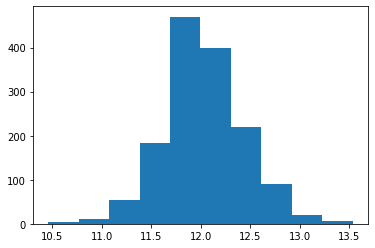

In [177]:
data['SalePrice'] = np.log1p(data['SalePrice'])
plt.hist(data['SalePrice'])


Перейдем непосредственно к построению моделей. Разобьем выборку на обучение и контроль.

*Пожалуйста, **не меняйте** значение `random_state` в следующей ячейке.*

In [178]:
X = data[data.columns[:-1]]
y = data[data.columns[-1:]]
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=17032019)

In [179]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1094, 222), (365, 222), (1094, 1), (365, 1))

## 7 (2)

Примените к данным следующие алгоритмы:

- kNN
- линейная регрессия
- Lasso
- Ridge

Для каждого из методов подберите гиперпараметры с помощью кросс-валидации. Обучите алгоритмы с лучшими гиперпараметрами на обучающей выборке и оцените качество по метрике **Root** Mean Squared Error. Какой из методов показывает себя лучше?

#### KNN

In [239]:
knn = KNeighborsRegressor(n_neighbors=4, weights='uniform')
knn.fit(X_train, y_train)
predictions = knn.predict(X_val)
sqrt(mean_squared_error(y_val, predictions))

0.27260790247744227

In [240]:

grid_searcher = GridSearchCV(
    KNeighborsRegressor(),
    param_grid={
        'n_neighbors': range(1,50, 2),
        'weights': ['uniform', 'distance'],
        'p': [1, 2, 3]
    },
    cv=5, iid=True, n_jobs=-1
)

In [241]:
%%time
grid_searcher.fit(X_train, y_train)
best_predictions = grid_searcher.predict(X_val)
grid_searcher.best_params_

CPU times: user 2.55 s, sys: 433 ms, total: 2.99 s
Wall time: 25.9 s


{'n_neighbors': 49, 'p': 1, 'weights': 'distance'}

In [242]:
knn = KNeighborsRegressor(n_neighbors=49, weights='distance', p=1)

knn.fit(X_train, y_train)
predictions = knn.predict(X_val)
sqrt(mean_squared_error(y_val, predictions))

0.23512134269719742

#### Линейная регрессия

In [243]:
lr = LinearRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_val)
sqrt(mean_squared_error(y_val, predictions))

0.07475859907224175

In [244]:
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

grid_searcher_lr = GridSearchCV(
    LinearRegression(),
    param_grid=parameters,
    cv=5, iid=True
)

In [245]:
%%time
grid_searcher_lr.fit(X_train, y_train);
best_predictions = grid_searcher_lr.predict(X_val)
grid_searcher_lr.best_params_

CPU times: user 1.68 s, sys: 46 ms, total: 1.73 s
Wall time: 873 ms


{'copy_X': True, 'fit_intercept': True, 'normalize': False}

In [246]:
lr = LinearRegression(fit_intercept=True, normalize=False, copy_X=True) 
lr.fit(X_train, y_train)
predictions = lr.predict(X_val)
sqrt(mean_squared_error(y_val, predictions,))

0.07475859907224175

#### Lasso

In [247]:
la = Lasso(alpha=2)
la.fit(X_train, y_train)
predictions = la.predict(X_val)
sqrt(mean_squared_error(y_val, predictions))

0.240157898974266

In [248]:
def frange(start, stop, step):
        i = start
        while i < stop:
            yield i
            i += step

parameters = {'alpha':[0.01, 0.05, 0.1, 0.5, 1, 2],'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

grid_searcher_la = GridSearchCV(
    Lasso(),
    param_grid=parameters,
    cv=5, iid=True, n_jobs = -1
)

In [249]:
grid_searcher_la.fit(X_train, y_train);
best_predictions = grid_searcher_la.predict(X_val)
grid_searcher_la.best_params_

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.9299925387086, tolerance: 0.010100000000000001
  positive)


{'alpha': 0.01, 'copy_X': True, 'fit_intercept': False, 'normalize': True}

In [250]:
la = Lasso(alpha=0.01, copy_X=True, fit_intercept=True, normalize=False)
la.fit(X_train, y_train)
predictions = la.predict(X_val)
sqrt(mean_squared_error(y_val, predictions))

0.08250659181111153

#### Ridge

In [251]:
ri = Ridge(alpha=2)
ri.fit(X_train, y_train)
predictions = ri.predict(X_val)
sqrt(mean_squared_error(y_val, predictions))

0.07439437344002327

In [252]:
parameters = {'alpha':[0.1, 0.5, 1, 2, 3],'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

grid_searcher_ri = GridSearchCV(Ridge(), parameters,cv=5)

grid_searcher_ri.fit(X_train, y_train);
best_predictions = grid_searcher_ri.predict(X_val)
grid_searcher_ri.best_params_
grid_searcher_ri.best_estimator_

Ridge(alpha=0.5, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=0.001)

In [253]:
ri = Ridge(alpha=0.5, copy_X=True, fit_intercept=False, normalize=True)
ri.fit(X_train, y_train)
predictions = ri.predict(X_val)
sqrt(mean_squared_error(y_val, predictions))

0.07396977462828563

## 8 (1)

Постройте гистограммы значений весов для линейной регрессии, Lasso и Ridge. Опишите наблюдения. В чем различия между полученными наборами весов и почему?

[Text(0, 0, '-2.0000000000000003e-10'),
 Text(0, 0, '0.0'),
 Text(0, 0, '2.0000000000000003e-10'),
 Text(0, 0, '4.000000000000001e-10'),
 Text(0, 0, '6.000000000000001e-10'),
 Text(0, 0, '8.000000000000001e-10'),
 Text(0, 0, '1.0000000000000003e-09'),
 Text(0, 0, '1.2000000000000002e-09')]

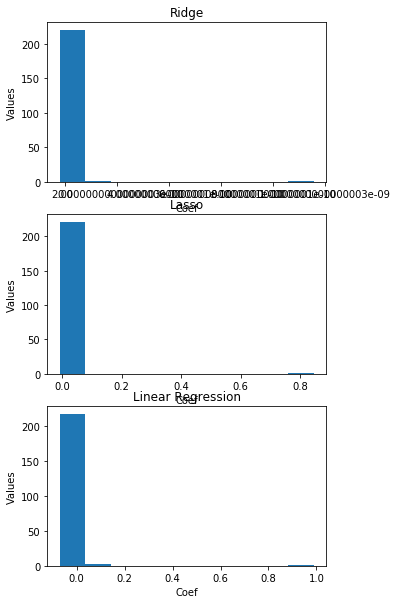

In [260]:
fig, ax = plt.subplots(3, figsize=(5, 10))

ax[0].hist(pd.DataFrame(grid_searcher_ri.best_estimator_.coef_))
ax[0].set_title('Ridge')
ax[0].set_xlabel('Coef')
ax[0].set_ylabel('Values')

ax[1].hist(grid_searcher_la.best_estimator_.coef_)
ax[1].set_title('Lasso')
ax[1].set_xlabel('Coef')
ax[1].set_ylabel('Values')

ax[2].hist(pd.DataFrame(grid_searcher_lr.best_estimator_.coef_))
ax[2].set_title('Linear Regression')
ax[2].set_xlabel('Coef')
ax[2].set_ylabel('Values')

ticks = ax[0].get_xticks()*10**(-9)
ax[0].set_xticklabels(ticks)